## Compare with model results and interpretability from DeepMol

Load the dataset from a CSV

In [1]:
from collections import Counter
from deepmol.loaders.loaders import CSVLoader
import pandas as pd
from deepmol.splitters.splitters import SingletaskStratifiedSplitter
from copy import deepcopy
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from deepmol.metrics import Metric
from sklearn.metrics import roc_auc_score, accuracy_score
from deepmol.feature_importance import ShapValues
from deepmol.compound_featurization import MorganFingerprint

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Mol2Vec not available. Please install it to use it. (pip install git+https://github.com/samoturk/mol2vec#egg=mol2vec)


In [2]:
ds = pd.read_csv('data/tox21.csv')
ds.dropna(subset=['SR-p53'],inplace=True)
ds.fillna(0, inplace=True)
ds.drop('mol_id', axis=1, inplace=True)
ds.shape

(6774, 13)

In [3]:
ds.to_csv("data/deepmol_dataset.csv", sep=',', index=True,index_label="id", encoding='utf-8')

loader = CSVLoader(dataset_path='data/deepmol_dataset.csv',
                   smiles_field='smiles',
                   id_field='id',
                   labels_fields=['SR-p53'],
                   features_fields=['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD','NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP'],
                   shard_size=6774,
                   mode='auto')

In [4]:
dataset = loader.create_dataset()
dataset.get_shape()

[13:41:25] WARNING: not removing hydrogen atom without neighbors


2024-05-31 13:41:25,823 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!
2024-05-31 13:41:25,826 — INFO — Mols_shape: (6774,)
2024-05-31 13:41:25,828 — INFO — Features_shape: (6774, 11)
2024-05-31 13:41:25,829 — INFO — Labels_shape: (6774,)


((6774,), (6774, 11), (6774,))

Pre-processing


In [5]:
Counter(dataset.y)

Counter({0.0: 6351, 1.0: 423})

In [6]:
from deepmol.imbalanced_learn import RandomUnderSampler

d3 = deepcopy(dataset)
sampler = RandomUnderSampler(sampling_strategy=0.75, random_state=123, replacement=True)
d3 = sampler.sample(d3)

Counter(d3.y)   

Counter({0.0: 564, 1.0: 423})

In [7]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=d3, frac_train=0.7,
                                                                             frac_valid=0.15, frac_test=0.15)

Model: RandomForest

In [8]:
rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

SklearnModel(model=RandomForestClassifier(),
             model_dir='C:\\Users\\joaop\\AppData\\Local\\Temp\\tmp_zk483gz')

In [9]:
model.evaluate(test_dataset, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])
model.save('rf_model')

Model1: GraphConvModel

In [10]:
from deepmol.compound_featurization import ConvMolFeat

train_dataset_conv = ConvMolFeat(n_jobs=10).featurize(train_dataset, inplace=False)
test_dataset_conv = ConvMolFeat(n_jobs=10).featurize(test_dataset, inplace=False)
valid_dataset_conv = ConvMolFeat(n_jobs=10).featurize(valid_dataset, inplace=False)


In [11]:
from deepchem.models import GraphConvModel
from deepmol.models import DeepChemModel

model1 = DeepChemModel(model=GraphConvModel, epochs=100, verbose=1, n_tasks=1, graph_conv_layers=[32, 32], dense_layer_size=128)
model1.fit(train_dataset_conv)

In [12]:
model1.evaluate(test_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.6852022058823529, 'accuracy_score': 0.7046979865771812},
 {})

In [13]:
model1.evaluate(valid_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7809523809523811, 'accuracy_score': 0.7837837837837838},
 {})

Explaining Model1

In [14]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 124
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi_conv, patt_number)

Prediction:  0
Actual Value:  0.0
2024-05-31 13:42:18,772 — INFO — Pattern does not match molecule! Active bits: [ 49  62 113 125 127 143 144 145 150 152 157 162 163 164 165]


In [15]:
from rdkit import Chem
import numpy as np

fp = MorganFingerprint()
fingerprint = fp._featurize(smi_conv)

activated_bits = np.where(fingerprint == 1)[0]
activated_bits = list(activated_bits)

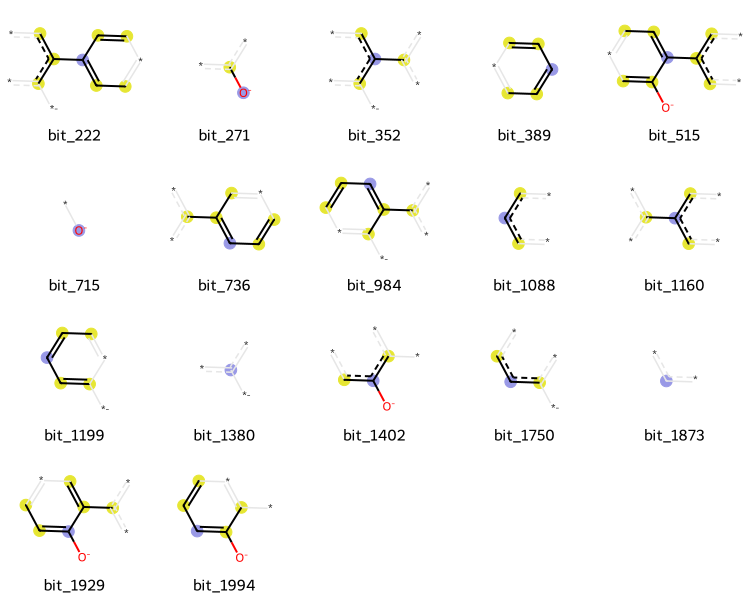

In [16]:
MorganFingerprint().draw_bits(smi_conv, activated_bits)

Explaining Model

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

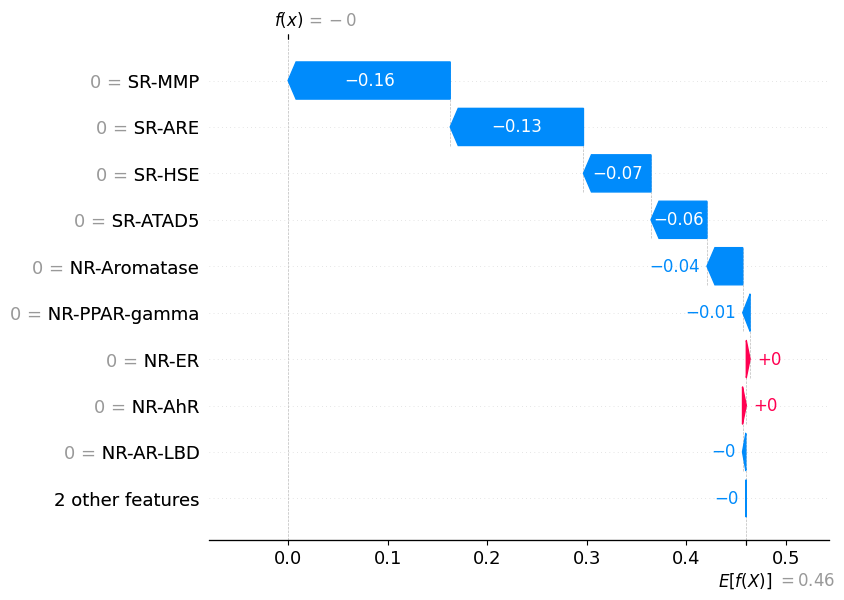

In [17]:
# compute shap values
shap_calc = ShapValues()
shap_calc.fit(train_dataset, model)
shap_calc.sample_explanation_plot(index=1, plot_type='waterfall')

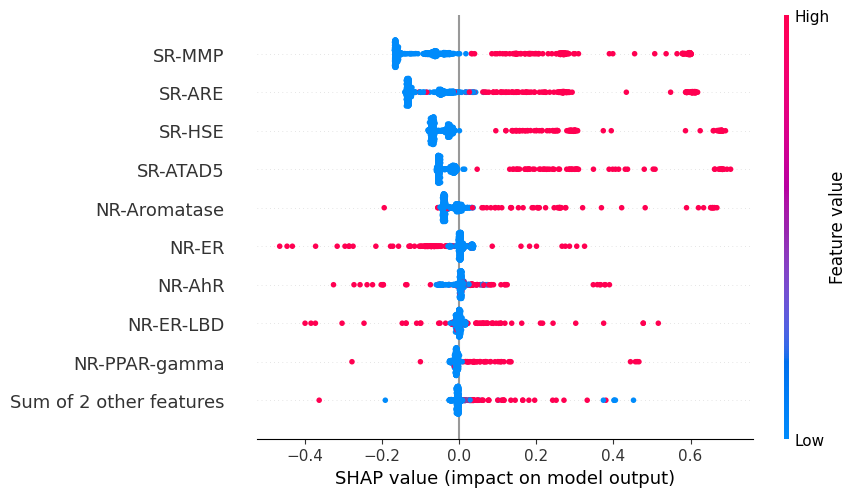

In [18]:
shap_calc.beeswarm_plot()

In [19]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 66
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

Prediction:  0
Actual Value:  0.0


In [20]:
from rdkit.Chem import rdMolDescriptors
morgan_fp = MorganFingerprint()
fingerprint = morgan_fp._featurize(smi_conv)

activated_bits = np.where(fingerprint == 1)[0]
activated_bits = list(activated_bits)

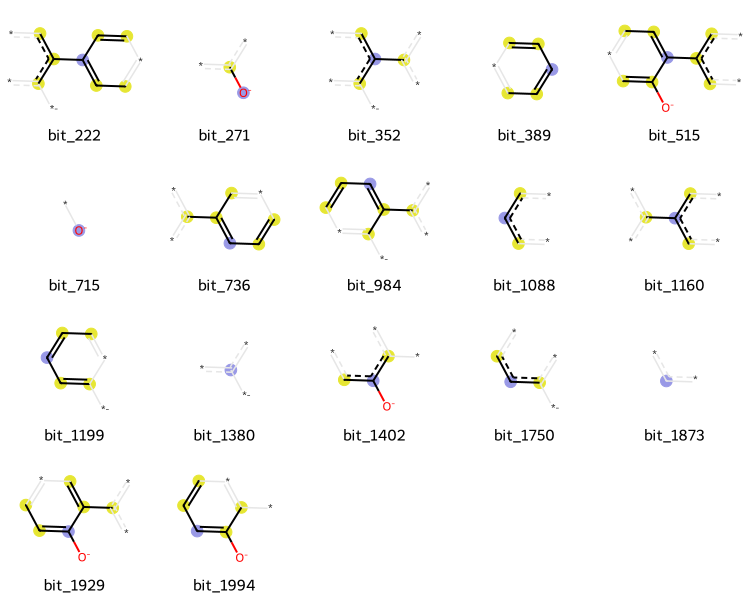

In [21]:
MorganFingerprint().draw_bits(smi_conv,activated_bits)

In [22]:
patt_number = 104 
mol_number = 2

prediction = model.predict(test_dataset)[mol_number]
actual_value = test_dataset.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_dataset.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

Prediction:  1.0
Actual Value:  0.0


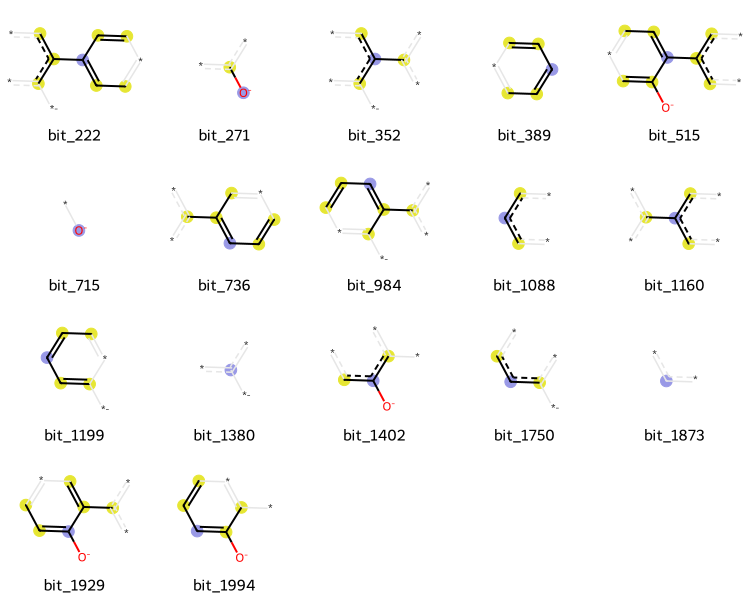

In [23]:
morgan_fp = MorganFingerprint()
fingerprint = morgan_fp._featurize(smi)

activated_bits = np.where(fingerprint == 1)[0]
activated_bits = list(activated_bits)
MorganFingerprint().draw_bits(smi, activated_bits)